In [19]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import pandas as pd
from datetime import datetime
import os

import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import VAR
from scipy.stats import pearsonr

pd.set_option('display.max_columns', 500)




In [20]:
files = os.listdir('ssw_events_saved_filtered/')

In [21]:
# Load all data into one dataframe
df_all = pd.DataFrame()
for file in files:
    df = pd.read_csv("ssw_events_saved_filtered/" + file)
    # add an t_ column that is 0 for when SSW_flah is true and increases by 1 after that value and decreases by one before that value
    df = df.sort_values(by='dates', ascending=True)
    # add central date column, that identifies a dataset by its central date
    df['central_date'] = df.iloc[21].dates    
    # concat df with df_all
    df_all = pd.concat([df,df_all])
    


# sort df_all by dates
df_all = df_all.sort_values(by='dates', ascending=True)
# add an index column
df_all['index_'] = range(1, len(df_all) + 1)
# select year to a column
df_all['year'] = pd.DatetimeIndex(df_all['dates']).year
# load df_merged into a Pandas DataFrame and merge it with df_all
df_merged = pd.read_csv("df_merged.csv")
# merge df_all and df_merged on all common dates  
df_all = pd.merge(df_all, df_merged[['dates','mf_abs','mf_abs_zscore','mf_abs_zscore_abs']], on='dates', how='inner')


In [22]:
df_all

,dates,wind_eastward_mean,wind_eastward_mean_selection,temperature_mean_selection,wind_eastward_mean_cos,SSW_flag,t_delta,central_date,index_,year,mf_abs,mf_abs_zscore,mf_abs_zscore_abs
0,2002-12-28,30.166703,15.994463,213.120404,15.083352,False,-20,2003-01-18,1,2002,0.001234,0.244843,0.244843
1,2002-12-29,24.246168,23.902853,236.805942,12.123084,False,-19,2003-01-18,2,2002,0.001229,0.240686,0.240686
2,2002-12-30,18.283184,27.995896,254.121855,9.141592,False,-18,2003-01-18,3,2002,0.000714,-0.133737,0.133737
3,2002-12-31,14.298763,27.821467,255.428372,7.149382,False,-17,2003-01-18,4,2002,0.000708,-0.137958,0.137958
4,2003-01-01,12.900051,39.659105,245.135665,6.450025,False,-16,2003-01-18,5,2003,0.000575,-0.234911,0.234911
...,...,...,...,...,...,...,...,...,...,...,...,...,...
393,2018-02-27,1.959706,-28.169621,240.048052,0.979853,False,16,2018-02-12,406,2018,0.000124,-0.562793,0.562793
394,2018-02-28,7.124685,-21.560767,241.991318,3.562342,False,17,2018-02-12,407,2018,0.000220,-0.492712,0.492712
395,2018-03-01,8.236222,-10.779783,227.130560,4.118111,False,18,2018-02-12,408,2018,0.000151,-0.543068,0.543068
396,2018-03-02,8.793968,-4.203825,228.684507,4.396984,False,19,2018-02-12,409,2018,0.000125,-0.562174,0.562174


In [23]:
# =================================================================================================
# Plot absolute Momemtum flux with Plotly
# =================================================================================================

# group df by year and plot the mean of each year
df = df_all

df_grouped = df.groupby('central_date')

fig = go.Figure()

for year, dataframe in df_grouped:
    # plot the mean of each year using plotly
    # fig.add_trace(go.Scatter(x=df['t_delta'], y=df['wind_eastward_mean_cos'], name=f'ZMZW{year}', line=dict()))
    fig.add_trace(go.Scatter(x=dataframe['t_delta'], y=dataframe['mf_abs'], name=f'Momentum Flux ({year})', line=dict(), yaxis='y2'))

    
fig.update_layout(
    yaxis=dict(
        range=[-20, 50],
        title='ZMZW in m/s'
    )
    ,yaxis2=dict(
        range=[-0.0, 0.005],
        title='Absolute Momentum Flux',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    title=f'Plot Absolute Momentum Flux centered around the first day of a sudden Stratospheric Warming ',
    legend=dict(orientation="h", y=1.2, x=0.5))

# Show the plot
fig.show()

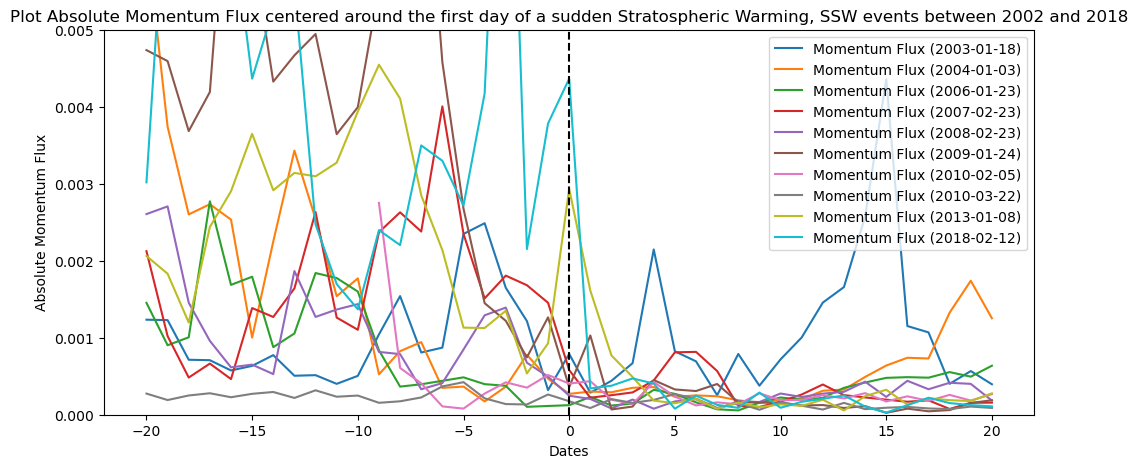

In [28]:
# =================================================================================================
# Plot absolute Momemtum flux with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

df = df_all

df_grouped = df.groupby('central_date')

fig, ax1 = plt.subplots(figsize=(12, 5))

for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['mf_abs'], label=f'Momentum Flux ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Dates')
ax1.set_ylabel('Absolute Momentum Flux')
ax1.set_ylim([-0.0, 0.005])
ax1.tick_params(axis='y')

# add vertical line at t_delta = 0
ax1.axvline(x=0, color='black', linestyle='--')


plt.title('Plot Absolute Momentum Flux centered around the first day of a sudden Stratospheric Warming, SSW events between 2002 and 2018')
plt.legend(loc='upper right')

plt.show()


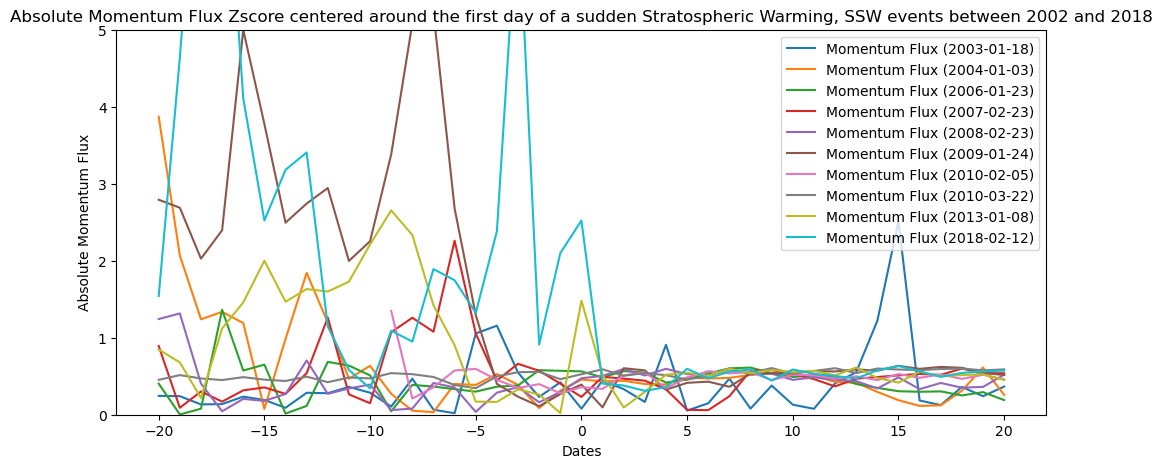

In [30]:
# =================================================================================================
# Plot absolute Zscore of momentum flux with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

df = df_all
df_grouped = df.groupby('central_date')
fig, ax1 = plt.subplots(figsize=(12, 5))
for year, dataframe in df_grouped:
    ax1.plot(dataframe['t_delta'], dataframe['mf_abs_zscore_abs'], label=f'Momentum Flux ({year})')
    
# Set the axis labels and titles
ax1.set_xlabel('Dates')
ax1.set_ylabel('Absolute Momentum Flux')
ax1.set_ylim([0,5])
ax1.tick_params(axis='y')


plt.title('Absolute Momentum Flux Zscore centered around the first day of a sudden Stratospheric Warming, SSW events between 2002 and 2018')
plt.legend(loc='upper right')

plt.show()


In [9]:
# Calculate avs and stds to plot over time for all ssw
avgs = df.mean()
devs = df.std()

for col in ['mf_abs', 'wind_eastward_mean_cos']:
    df[col] = (df[col] - avgs.loc[col]) / devs.loc[col]

# =================================================================================================
# Plot normalized absolute Momemtum flux and ZMZW with Plotly
# =================================================================================================

fig = go.Figure()

fig.add_trace(go.Scatter(x=df['index_'], y=df['wind_eastward_mean_cos'], name='wind_eastward_mean_selection', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=df['index_'], y=df['mf_abs'], name='mf_abs', line=dict(color='orange'), yaxis='y2'))

# Set layout
fig.update_layout(
    yaxis=dict(
        range=[-5, 5],
        title='wind_eastward_mean_cos'
    )
    ,yaxis2=dict(
        range=[-5, 5],
        title='mf_abs',
        side='right',
        overlaying='y'
    )
    ,xaxis=dict(title='Dates'),
    title=f'ZMZW at 60◦ N latitude and Temperature, 1970 t0 2016',
    legend=dict(orientation="h", y=1.2, x=0.5))

# Show the plot
fig.show()

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_3979/373486461.py:2: FutureWarning:

The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.

/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_3979/373486461.py:3: FutureWarning:

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.



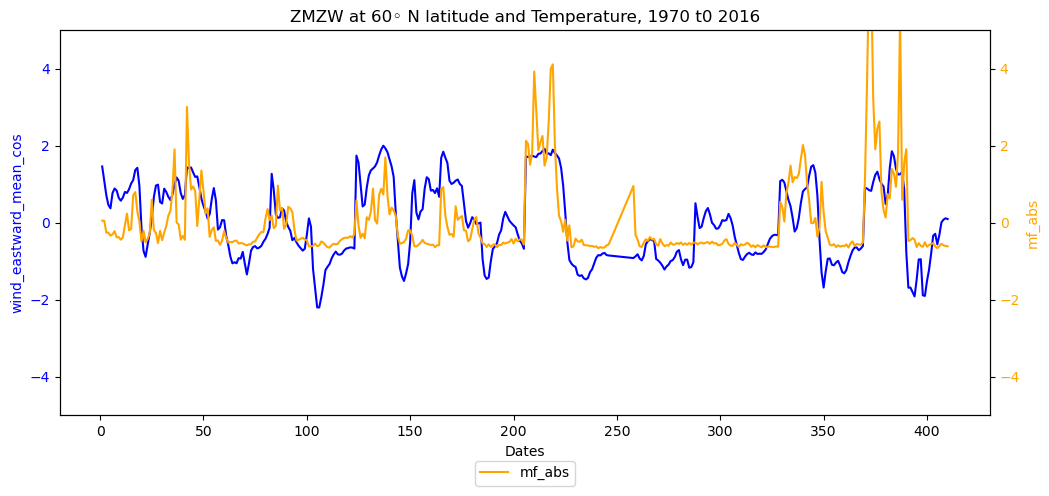

In [10]:
# =================================================================================================
# Plot normalized absolute Momemtum flux and ZMZW with Matplotlib
# =================================================================================================

import matplotlib.pyplot as plt

# Plot the data
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(df['index_'], df['wind_eastward_mean_cos'], color='blue', label='wind_eastward_mean_selection')
ax1.set_xlabel('Dates')
ax1.set_ylabel('wind_eastward_mean_cos', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_ylim([-5, 5])

ax2 = ax1.twinx()

ax2.plot(df['index_'], df['mf_abs'], color='orange', label='mf_abs')
ax2.set_ylabel('mf_abs', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim([-5, 5])

# Add title and legend
plt.title('ZMZW at 60◦ N latitude and Temperature, 1970 t0 2016')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

plt.show()


In [11]:
# =================================================================================================
# Run VAR for absolute momentum flux
# =================================================================================================

# group df by central_date
main_params_df = pd.DataFrame()

var = 'temperature_mean_selection'

df_grouped = df_all.groupby('central_date')

for central_date, dataframe in df_grouped:
    print('=============>' ,central_date)

    avgs = dataframe.mean(numeric_only=True)
    devs = dataframe.std(numeric_only=True)

    for col in [var, 'wind_eastward_mean_cos']:
        dataframe[col] = (dataframe[col] - avgs.loc[col]) / devs.loc[col]

    
    # plot_pacf(df['wind_eastward_mean_cos'])
    # plt.show()
    # plot_pacf(df['mf_abs'])
    # plt.show()


    for lag in range(1, 20):
        temp_series = dataframe[var].iloc[lag:]
        wind_series = dataframe['wind_eastward_mean_cos'].iloc[:-lag]
        # print('Lag: %s'%lag)
        # print(pearsonr(temp_series, wind_series))
        # print('------')

    dataframe = dataframe[['wind_eastward_mean_cos',var]]
    model = VAR(dataframe)
    model_fit = model.fit(maxlags=10)
    
    df_params = model_fit.params

    # add name to first column in df_params
    df_params =df_params.reset_index()

    # exclude first row from df_params
    df_params = df_params.iloc[1:]

    standard_error = model_fit.pvalues
    # rename column headers in standard_error
    standard_error = standard_error.reset_index()
    standard_error = standard_error.rename(columns={'wind_eastward_mean_cos':'wind_eastward_mean_cos_se',var:f'{var}_se'})
    standard_error = standard_error.iloc[1:]
    
    
    # create a new column with the first two characters of index
    df_params['var'] = df_params['index'].str[:3]

    # create a new column with the the characters after the first two characters of index
    df_params['lag'] = df_params['index'].str[3:]

    df_params['var'] = df_params['var'].apply(lambda x: x.strip('.'))
    df_params['lag'] = df_params['lag'].apply(lambda x: x.strip('.'))

    # select only columns lag where it's equal to wind_eastward_mean_cos
    df_params = df_params[df_params['lag'] == 'wind_eastward_mean_cos']

    df_params['identifier'] = central_date

    df_params = pd.merge(df_params, standard_error, on=['index'])

    # concatenate df_params to main_params_df
    main_params_df = pd.concat([main_params_df, df_params])



/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



=============> 2003-01-18
=============> 2004-01-03
=============> 2006-01-23
=============> 2007-02-23
=============> 2008-02-23
=============> 2009-01-24
=============> 2010-02-05
=============> 2010-03-22
=============> 2013-01-08
=============> 2018-02-12


/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

/Users/joaojesus/opt/anaconda3/envs/main_fyp_env/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

An unsupported index was provided

In [12]:
# =================================================================================================
# get correlation coeficients for each identifier
# =================================================================================================

coefs_arr = []
for identifier, dataframe in main_params_df.groupby('identifier'):
    coefs_arr.append(dataframe['wind_eastward_mean_cos'].values)

# =================================================================================================
# get p values for each identifier
# =================================================================================================

coefs_arr_se = []
for identifier, dataframe in main_params_df.groupby('identifier'):
    coefs_arr_se.append(dataframe['wind_eastward_mean_cos_se'].values)

In [13]:
# =================================================================================================
# Plot corr coeficients for each identifier (SSW starte date) and lag
# =================================================================================================

import plotly.express as px

dates = main_params_df['identifier'].unique()
dates.sort()

fig = px.imshow(coefs_arr, text_auto=True, aspect="auto")

# add title to the figure
# Add row labels to the figure
tickvals = list(enumerate(dates))

fig.update_layout(
    title="Correlation Matrix",
    yaxis=dict(
        tickmode='array', 
        tickvals=np.arange(len(dates)),
        ticktext=dates,
        title='Start Date of the SSW event'
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=np.arange(np.shape(coefs_arr)[1]),
        title='Lag (in days)'
    )
)

fig.show()

In [14]:
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag
# =================================================================================================

import plotly.express as px

dates = main_params_df['identifier'].unique()
dates.sort()

fig = px.imshow(coefs_arr_se, text_auto=True, aspect="auto")

# add title to the figure
# Add row labels to the figure
tickvals = list(enumerate(dates))

fig.update_layout(
    title="Significance Matrix",
    yaxis=dict(
        tickmode='array', 
        tickvals=np.arange(len(dates)),
        ticktext=dates,
        title='Start Date of the SSW event'
    ),
    xaxis=dict(
        tickmode='array',
        tickvals=np.arange(np.shape(coefs_arr_se)[1]),
        title='Lag (in days)'
    ),
        coloraxis=dict(
        cmin=0,
        cmax=1
    )
)

fig.show()

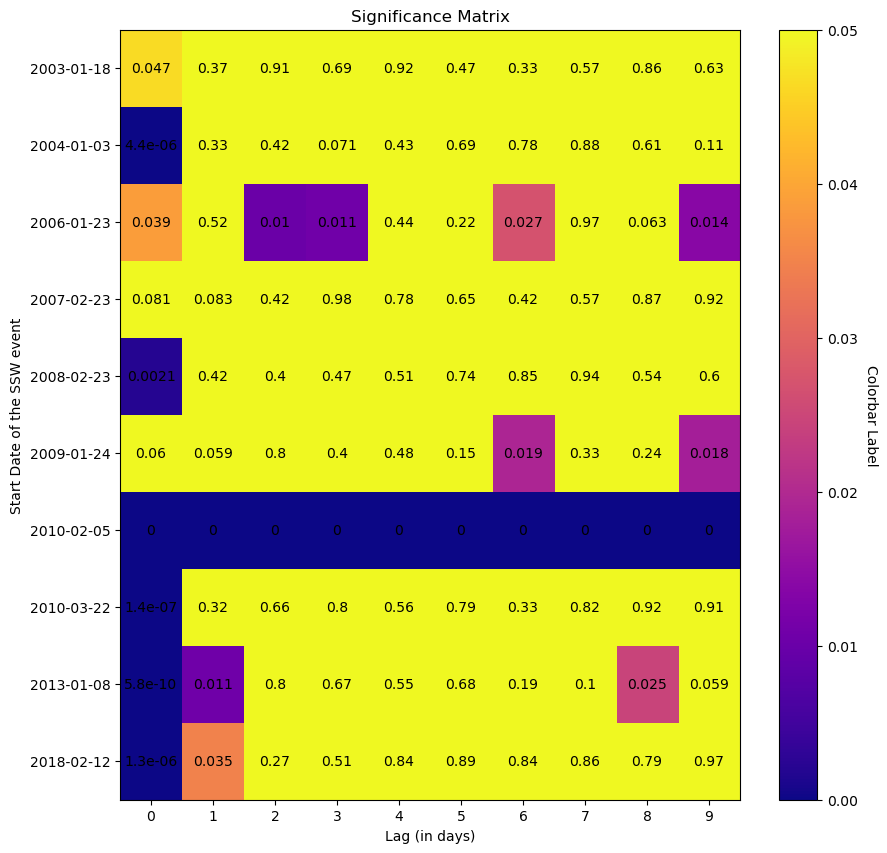

In [15]:
# =================================================================================================
# Plot p values for each identifier (SSW starte date) and lag, using matplotlib
# =================================================================================================

import matplotlib.pyplot as plt
import numpy as np

dates = main_params_df['identifier'].unique()
dates.sort()

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(coefs_arr_se, aspect="auto",cmap='plasma')

# set the color gradient
im.set_clim(0, 0.05)

# add title to the figure
ax.set_title("Significance Matrix")

# Add row labels to the figure
tickvals = np.arange(len(dates))
ax.set_yticks(tickvals)
ax.set_yticklabels(dates)
ax.set_ylabel('Start Date of the SSW event')

ax.set_xticks(np.arange(np.shape(coefs_arr_se)[1]))
ax.set_xlabel('Lag (in days)')

# add color bar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Colorbar Label', rotation=-90, va="bottom")

# add numerical values to each box
for i in range(len(dates)):
    for j in range(np.shape(coefs_arr_se)[1]):
        text = ax.text(j, i, "{:.2g}".format(coefs_arr_se[i][j]),
                       ha="center", va="center", color="black")

plt.show()



In [16]:
coefs_arr_se[i, j]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
i

0

In [ ]:
j

0

In [ ]:
coefs_arr_se[0][0]

0.04653303214796445